In [1]:
import gurobipy as gb
import numpy as np
import matplotlib.pyplot as plt
from pickle import load, dump
from ipywidgets import widgets, interactive_output
from IPython.display import display

''' 
   Parameters setting
'''
h = 8; c = 5*h; f = 2*15*h

# Results

In [2]:
def check_objectives(it, T, G, S, phi, f, h, y, I, ntabs=0):

    objs = [sum(f*y[o][t] + h*sum(phi[s]*sum(I[o][s][t,g] for g in G) for s in S) for t in T) for o in [0,1]]
    if round(objs[0],4) != round(objs[1],4): print("\t"*ntabs + f"{it} Objectives differ. Standard = {round(objs[0],2)}. Transp. = {round(objs[1],2)}")

def show_age_sl_results(T, G, S, alpha, d, y, z, show=True):
    fig, axes = plt.subplots(nrows=len(G), ncols=len(T)+3, figsize=(22, 4))
    fig.subplots_adjust(wspace=0, hspace=0)

    sl = dict(); total_sl = dict(); cm = plt.get_cmap("RdYlGn")
    for g in G:
        for t in T:
            sl[t,g] = [sum(z[s][t,k] for k in range(g+1))/d[s][t] for s in S]
            axes[g][t+2].hist(sl[t,g], bins=[i/10  for i in range(10)]+[1.01], color=cm(sum(sl[t,g])/len(S)), alpha=1)
            axes[g][t+2].set_xlim(-0.2, 1.2); axes[g][t+2].set_ylim(-5,len(S)+5)
            axes[g][t+2].set_yticks([]); axes[g][t+2].set_xticks([0,0.25,0.5,0.75,1]); axes[g][t+2].set_xticklabels([])
            axes[g][t+2].text(x=0.5, y=len(S)/2+2.5, s=f"{sum(sl[t,g])/len(S):.0%}", va="center", ha="center", fontsize=12)
        
        axes[g][0].spines[["bottom","top","left","right"]].set_visible(False); axes[g][2].spines[["bottom","top","left","right"]].set_visible(False)
        axes[g][0].set_xlim(0,2); axes[g][2].set_xlim(0,2)
        axes[g][0].set_ylim(0,2); axes[g][0].set_xticks([]); axes[g][0].set_yticks([])
        axes[g][2].set_ylim(0,2); axes[g][2].set_xticks([]); axes[g][2].set_yticks([])
        axes[g][0].text(x=1, y=1, s=f"g = {g}\n"+fr"$\alpha_{g}$ = {alpha[g]:.0%}", va="center", ha="center", fontsize=11)

        total_ix = 1
        total_sl[g] = [sum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S]
        axes[g][total_ix].hist(total_sl[g], bins=[i/10 for i in range(11)], color = cm(sum(total_sl[g])/len(S)), alpha = 1)
        axes[g][total_ix].set_xlim(-0.2, 1.2); axes[g][total_ix].set_ylim(-5,len(S)+5)
        axes[g][total_ix].set_yticks([]); axes[g][total_ix].set_xticks([0,0.25,0.5,0.75,1]); axes[g][total_ix].set_xticklabels([])
        axes[g][total_ix].text(x=0.5, y=len(S)/2+2.5, s=f"{sum(total_sl[g])/len(S):.0%}", va="center", ha="center", fontsize=12)
        if round(sum(total_sl[g])/len(S),4) == alpha[g]:
            axes[g][total_ix].vlines(x = [-0.15, 1.15], ymin=-5, ymax=len(S)+5, linewidth=5, color="gold")
            axes[g][total_ix].hlines(y = [-2.5, len(S)+2.5], xmin=-0.2, xmax=1.2, linewidth=5, color="gold")
        axes[g][total_ix].vlines(x=1.2, ymin=-5, ymax=len(S)+5, color="black")
        
    for t in [0]+T:
        if t in T:
            if y[t]: col = "midnightblue"; weight = "bold"
            else: col = "black"; weight = "normal"
            axes[0][t+2].set_title(f"t = {t}", color=col, fontweight=weight)
            axes[-1][t+2].set_xticklabels(["0","","50","","100"], fontsize=8)
        else:
            axes[0][total_ix].set_title("Total"); axes[-1][total_ix].set_xticklabels(["0","","50","","100"], fontsize=8)

    fig.suptitle("Total age-dependent service level constraints analysis", fontsize=16, y = 1.05)

    if not show: plt.close()

    return sl, total_sl

def waste_level_analysis(T, G, S, a0, an1, n, x, I, show = True):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16,6), width_ratios=[6,2,6,2])
    fig.subplots_adjust(hspace=0.25)

    waste = dict()

    cm = plt.get_cmap("nipy_spectral")
    for a in a0:

        for b in an1:
            if a <= b:
                waste[a,b] = [sum(I[a,b][s][t,n-1] for t in T)/sum(x[a,b][t] for t in T) for s in S]

        col = cm((a-a0[0])/(a0[-1]-a0[0]))
        axes[0].plot([b for b in an1 if a <= b], [sum(waste[a,b])/len(S) for b in an1 if a <= b], color=col, marker="X", markersize=4)

    ub = int(np.ceil(sum(waste[a0[-1],an1[-1]])/(0.05*len(S))))
    ticks = [i*0.05*ub/5 for i in range(6)]
    axes[0].set_yticks(ticks); axes[0].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[0].set_ylim(0,ticks[-1])

    axes[0].set_title("Total waste level",fontsize=16)
    axes[0].set_xlim(an1[0]-0.025, an1[-1]+0.025)
    axes[0].spines[["top","right"]].set_visible(False)
    axes[0].set_xticks(an1)
    axes[0].set_xticklabels([f"{b:.0%}" if b*100 % 5 == 0 else "" for b in an1], fontsize=12)
    axes[0].set_xlabel("Total service level target",fontsize=12)

    ix = 1
    for a in a0:
        col = cm((a-a0[0])/(a0[-1]-a0[0])); tcol = "black"
        axes[1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth = 4)
        axes[1].text(x=2.5, y=ix, s=f"{a:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[1].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{0}$", va="center", ha="center", fontsize=20)
    axes[1].set_xlim(0.5, 6)
    axes[1].set_ylim(-1, ix+2)
    axes[1].set_yticks([]); axes[1].set_xticks([])

    cm = plt.get_cmap("plasma")
    for b in an1:
        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
        axes[2].plot([a for a in a0 if a <= b], [sum(waste[a,b])/len(S) for a in a0 if a <= b], color=col, marker="X", markersize=4)

    axes[2].set_yticks(ticks); axes[2].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[2].set_ylim(0,ticks[-1])

    axes[2].set_title("Total waste level",fontsize=16)
    axes[2].set_xlim(a0[0]-0.025, a0[-1]+0.025)
    axes[2].spines[["top","right"]].set_visible(False)
    axes[2].set_xticks(a0)
    axes[2].set_xticklabels([f"{a:.0%}" if a*100 % 10 == 0 else "" for a in a0], fontsize=12)
    axes[2].set_xlabel("Fresh produce service level target",fontsize=12)

    ix = 1
    for b in an1:
        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9); tcol = "black"
        axes[3].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth=4)
        axes[3].text(x=2.5, y=ix, s=f"{b:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[3].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{G[-1]}$", va="center", ha="center", fontsize=20)
    axes[3].set_xlim(0.5, 6)
    axes[3].set_ylim(-1, ix+2)
    axes[3].set_yticks([]); axes[3].set_xticks([])

    fig.suptitle("Total waste level analysis", y=1, fontsize=18)

    if not show: plt.close()

    return waste

def period_fill_rate_analysis(T, G, S, a0, an1, d, z, show=True):


    nrows = int(np.ceil((len(an1))/3))
    fig, subp = plt.subplots(nrows=nrows, ncols=3, figsize=(24,4*nrows))
    fig.subplots_adjust(hspace = 0.25)

    ncharts = int(nrows*3)
    if ncharts > 3: axes = [subp[int(np.floor(ix/3)),ix%3] for ix in range(ncharts)]

    cm = plt.get_cmap("nipy_spectral")
    ix = 0; period_sl = dict()
    for b in an1:

        axes[ix].hlines(y=[b], xmin=-0.5, xmax=len(a0)-0.5, color="silver", linestyle="--")
        pos = 0
        for a in a0:
            if a <= b:
                
                col = cm((a-a0[0])/(a0[-1]-a0[0]))
                period_sl[a,b] = [sum(sum(z[a,b][s][t,g] for g in G)/d[s][t] for s in S)/len(S) for t in T]
                box = axes[ix].boxplot(x=period_sl[a,b], positions=[pos], widths=0.5, patch_artist = True)
                for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                    plt.setp(box[item], color=col)
                plt.setp(box["medians"], color="white")
                plt.setp(box["fliers"], markeredgecolor=col)

            pos += 1
        
        axes[ix].text(x=pos-2.5, y=0.05, s=fr"$\alpha_{G[-1]}$ = {b:.1%}", fontsize=16, va="center", ha="center")
        
        ticks = [f"{a:.0%}" for a in a0 if a <= b]
        axes[ix].set_xticks([i for i in range(len(ticks))]); axes[ix].set_xticklabels(ticks, fontsize=12)
        
        ticks = [i/5 for i in range(6)]
        axes[ix].set_yticks(ticks); axes[ix].set_yticklabels([f"{t:.0%}" for t in ticks], fontsize=12)
        
        ix += 1

    for ax in axes[:len(an1)]:
        ax.set_xlim(-0.5, len(a0)-0.5)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel("Fresh produce service level requirement", fontsize=12)

    if len(an1)+1 < ncharts:
        for m in range(len(an1), ncharts):
            axes[m].spines[["bottom","top","left","right"]].set_visible(False)
            axes[m].set_xticks([]); axes[m].set_yticks([])

    fig.suptitle("Fill rate per time period analysis", y=0.925, fontsize=16)

    if not show: plt.close()

    return period_sl



# Models

In [3]:
def stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta = 0, epsilon = 1, MIPFocus = 0,  FIFO = 0, output = False, verbose = False, time = False, threads=0):

    m = gb.Model("Standard Model")
    Tt = {t:[mm for mm in range(np.max((1,t)),np.min((T[-1],t+n-1)) + 1)] for t in T+[-tt for tt in range(n)]}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in period t \in T or not
    y = {t:m.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Produced quantity in period t \in T
    x = {t:m.addVar(name=f"x_{t}", vtype=gb.GRB.CONTINUOUS) for t in T}
    # Amount of product of age g \in G that is used to fulfill demand in period t \in T
    z = {s:{(t,g):m.addVar(name=f"z_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    # Lost sales of period t \in T
    l = {s:{t:m.addVar(name=f"l_{s,t}", vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Available inventory of product of age g \in G at the end of period t \in T
    I = {s:{(t,g):m.addVar(name=f"I_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    for s in S: I[s].update({(0,g):I0[g] for g in I0})

    ######################################
    # CONSTRAINTS
    ######################################

    for t in T:

        # Production capacity
        m.addConstr(x[t] <= np.min((C, np.max([sum(d[s][mm] for mm in Tt[t]) for s in S]) ))*y[t])

        for s in S:
            # Inventory of fresh produce
            m.addConstr(I[s][t,0] == x[t] - z[s][t,0])

            for g in G[1:]:
                # Inventory dynamics throughout the day   
                m.addConstr(I[s][t,g] == I[s][t-1,g-1] - z[s][t,g])

            # Demand fulfillment and lost sales modeling
            m.addConstr(gb.quicksum(z[s][t,g] for g in G) + l[s][t] == d[s][t])
        
        # Expected demand service level by time period
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,g] for g in G)/d[s][t] for s in S) >= beta)
    
    for g in G:
        # Total age service level constraint
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S) >= alpha[g])
    
    # Total waste control constraint
    m.addConstr(gb.quicksum(phi[s]*gb.quicksum(I[s][t,n-1] for t in T) for s in S) <= epsilon*gb.quicksum(x[t] for t in T))

    # FIFO constraints
    if FIFO == 1:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:
            for t in T:
                for g in G:
                    m.addConstr(I[s][t,g] <= np.min((C,sum(d[s][mm] for mm in Tt[t-g])))*(1-gamma[s][t,g]))

                    if g < G[-1]:
                        m.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g+1])
    
    elif FIFO == 2:
        r_pos = {s:{(t,g):m.addVar(name=f"rpos_{t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G[1:]} for s in S}
        r_neg = {s:{(t,g):m.addVar(name=f"rneg_{t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G[1:]} for s in S}

        for s in S:
            for t in T:
                for g in G[1:]:

                    m.addConstr(gb.quicksum(z[s][t,k] for k in G if k < g) == r_pos[s][t,g])
                    m.addConstr(r_pos[s][t,g] - r_neg[s][t,g] == gb.quicksum(z[s][t,k] for k in G) - gb.quicksum(I[s][t-1,k-1] for k in G if k >= g))
    
    elif FIFO == 3:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:

            for t in T:
                for g in G:

                    if g > 0:
                        m.addConstr(gb.quicksum(z[s][t,k] for k in G if k >= g) >= gb.quicksum(I[s][t-1,k-1] for k in G if k >= g) - C*sum(1 for k in G if k >= g)*(1-gamma[s][t,g]))
                    
                    m.addConstr(gb.quicksum(z[s][t,k] for k in G if k >= g) >= gb.quicksum(z[s][t,k] for k in G) - d[s][t]*gamma[s][t,g])

                    if g < G[-1]:
                        # Common
                        m.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        # Mixed 1
                        m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g+1])

                    # Mixed 2
                    m.addConstr(I[s][t,g] <= np.min((C,sum(d[s][mm] for mm in Tt[t-g])))*(1-gamma[s][t,g]))
    
    elif FIFO == 4:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}
        other = {s:{(t,g):m.addVar(name=f"other_{s,t,g}",vtype=gb.GRB.CONTINUOUS) for t in T for g in G[:-1]} for s in S}

        for s in S:
            for t in T:
                for g in G:
                    m.addConstr(I[s][t,g] <= np.min((C,sum(d[s][mm] for mm in Tt[t-g])))*(1-gamma[s][t,g]))
                    #m.addConstr(gb.quicksum(I[s][t,k] for k in G if k >= g) <= sum(C for k in G if k >= g)*(1-gamma[s][t,g]))

                    #if g > 0:
                    #    m.addConstr(gb.quicksum(z[s][t,k] for k in G if k < g) <= d[s][t]*gamma[s][t,g])
                    
                    if g < G[-1]:
                        #m.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g+1])

                        m.addConstr(other[s][t,g] <= gamma[s][t,g] + gamma[s][t,g+1])
                        m.addConstr(other[s][t,g] <= 2 - (gamma[s][t,g] + gamma[s][t,g+1]))
                        m.addConstr(other[s][t,g] >= gamma[s][t,g] - gamma[s][t,g+1])
                        m.addConstr(other[s][t,g] >= gamma[s][t,g+1] - gamma[s][t,g])
                
                m.addConstr(gb.quicksum(other[s][t,g] for g in G[:-1]) <= 1)


    ######################################
    # OBJECTIVE FUNCTION
    ######################################
    
    total_cost = gb.quicksum(f*y[t] + c*x[t] + h*gb.quicksum(phi[s]*gb.quicksum(I[s][t,g] for g in G) for s in S) for t in T)
    m.setObjective(total_cost)

    m.update()
    m.setParam("OutputFlag",output)
    m.setParam("MIPFocus",MIPFocus)
    m.setParam("Threads", threads)
    m.setParam("MIPGap",1e-5)
    m.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    print(m.Status)
    if not time:
        y = {t:round(y[t].x) for t in T}
        x = {t:round(x[t].x,10) for t in T}
        z = {s:{(t,g):round(z[s][t,g].x,10) for t in T for g in G} for s in S}
        l = {s:{t:round(l[s][t].x,10) for t in T} for s in S}
        w = {s:{t:round(I[s][t,n-1].x,10) for t in T} for s in S}
        I = {s:{(t,g):round(I[s][t,g].x,10) for t in T for g in G} for s in S}

        if verbose:
            print(f"\tObjective: {round(total_cost.getValue(),2)}")
            print(f"\t\tSetup: {f*sum(y[t] for t in T)}")
            print(f"\t\tExp. Holding: {h*sum(phi[s]*sum(I[s][t,g] for t in T for g in G) for s in S)}")
            print(f"\tRuntime: {round(m.runTime,4)}\n")

        return y, x, z, l, w, I
    else:
        return m.runTime, m.getObjective().getValue()


def stat_dyn_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta = 0, epsilon = 1, MIPFocus = 0,  FIFO = 0, output = False, verbose = False, time = False, threads=0):

    m = gb.Model("Standard Model")
    Tt = {t:[mm for mm in range(np.max((1,t)),np.min((T[-1],t+n-1)) + 1)] for t in T+[-tt for tt in range(n)]}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in period t \in T or not
    y = {t:m.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Produced quantity in period t \in T
    x = {s:{t:m.addVar(name=f"x_{t}", vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Amount of product of age g \in G that is used to fulfill demand in period t \in T
    z = {s:{(t,g):m.addVar(name=f"z_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    # Lost sales of period t \in T
    l = {s:{t:m.addVar(name=f"l_{s,t}", vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Available inventory of product of age g \in G at the end of period t \in T
    I = {s:{(t,g):m.addVar(name=f"I_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    for s in S: I[s].update({(0,g):I0[g] for g in I0})

    ######################################
    # CONSTRAINTS
    ######################################

    for t in T:

        for s in S:

            # Production capacity
            m.addConstr(x[s][t] <= np.min((C, sum(d[s][m] for m in Tt[t])))*y[t])

            # Inventory of fresh produce
            m.addConstr(I[s][t,0] == x[s][t] - z[s][t,0])

            for g in G[1:]:
                # Inventory dynamics throughout the day   
                m.addConstr(I[s][t,g] == I[s][t-1,g-1] - z[s][t,g])

            # Demand fulfillment and lost sales modeling
            m.addConstr(gb.quicksum(z[s][t,g] for g in G) + l[s][t] == d[s][t])
        
        # Expected demand service level by time period
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,g] for g in G)/d[s][t] for s in S) >= beta)
    
    for g in G:
        # Total age service level constraint
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S) >= alpha[g])
    
    # Total waste control constraint
    m.addConstr(gb.quicksum(phi[s]*gb.quicksum(I[s][t,n-1] for t in T)/(alpha[n-1]*sum(d[s][t] for t in T)) for s in S) <= epsilon)

    # FIFO constraints
    if FIFO == 1:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:
            for t in T:
                for g in G:
                    m.addConstr(I[s][t,g] <= np.min((C,sum(d[s][mm] for mm in Tt[t-g])))*(1-gamma[s][t,g]))

                    if g < G[-1]:
                        m.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g+1])

    ######################################
    # OBJECTIVE FUNCTION
    ######################################
    
    total_cost = gb.quicksum(f*y[t] + c*gb.quicksum(phi[s]*x[s][t] for s in S) + h*gb.quicksum(phi[s]*gb.quicksum(I[s][t,g] for g in G) for s in S) for t in T)
    m.setObjective(total_cost)

    m.update()
    m.setParam("OutputFlag",output)
    m.setParam("MIPFocus",MIPFocus)
    m.setParam("Threads", threads)
    m.setParam("MIPGap",1e-5)
    m.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    if not time:
        y = {t:round(y[t].x) for t in T}
        x = {s:{t:round(x[s][t].x,10) for t in T} for s in S}
        z = {s:{(t,g):round(z[s][t,g].x,10) for t in T for g in G} for s in S}
        l = {s:{t:round(l[s][t].x,10) for t in T} for s in S}
        w = {s:{t:round(I[s][t,n-1].x,10) for t in T} for s in S}
        I = {s:{(t,g):round(I[s][t,g].x,10) for t in T for g in G} for s in S}

        if verbose:
            print(f"\tObjective: {round(total_cost.getValue(),2)}")
            print(f"\t\tSetup: {f*sum(y[t] for t in T)}")
            print(f"\t\tExp. Holding: {h*sum(phi[s]*sum(I[s][t,g] for t in T for g in G) for s in S)}")
            print(f"\tRuntime: {round(m.runTime,4)}\n")

        return y, x, z, l, w, I
    else:
        return m.runTime, m.getObjective().getValue()


def stat_stat_transportation_model(T, G, S, phi, n, h, f, C, I0, d, alpha, beta = 0, epsilon = 1, MIPFocus = 0,  FIFO = False, output = False, verbose = False, time = False):

    mm = gb.Model("Transportation Model")
    Tt = {t:[m for m in range(t,np.min((T[-1],t+n-1)) + 1)] for t in T}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether or not there is production in time period t \in T
    y = {t:mm.addVar(name=f"y_{t}",vtype=gb.GRB.BINARY) for t in T}
    # Total production quantity in time period t \in T
    q = {t:mm.addVar(name=f"q_{t}",vtype=gb.GRB.CONTINUOUS) for t in T}
    # Quantity of product produced in t \in T that is used to fulfill demand in m \in T_t
    x = {s:{(t,m):mm.addVar(name=f"x_{s,t,m}",vtype=gb.GRB.CONTINUOUS) for t in T for m in Tt[t]} for s in S}
    # Amount of initial inventory of age g \in G - {n-1} used to fulfill demand in t \in {1, ..., n-g-1}
    r = {s:{(t,g):mm.addVar(name=f"r_{s,t,g}",vtype=gb.GRB.CONTINUOUS) for g in G[:-1] for t in range(1, n-g-1 + 1)} for s in S}
    # Available inventory of product of age g \in G at the end of time period t \in T
    I = {s:{(t,g):mm.addVar(name=f"I_{s,t,g}",vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    # Lost sales in period t \in T
    l = {s:{t:mm.addVar(name=f"l_{s,t}",vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Generated waste in period t \in T
    w = {s:{t:mm.addVar(name=f"w_{s,t}",vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Leftover product that was produced in t \in T
    v = {s:{t:mm.addVar(name=f"v_{s,t}",vtype=gb.GRB.CONTINUOUS) for t in T if t+n-1>T[-1]} for s in S}

    ######################################
    # CONSTRAINTS
    ######################################

    # Total production capacity
    for t in T:
        mm.addConstr(q[t] <= np.min((C, sum(np.max([d[s][m] for s in S]) for m in Tt[t])))*y[t])

    for s in S:

        # Initial inventory modeling
        for g in G[:-1]:
            mm.addConstr(I0[g] == gb.quicksum(r[s][t,g] for t in range(1, n-g-1 +1)) + w[s][n-g-1])

        for g in G[:-1]:
            for t in T:

                # Inventory of time periods and ages for which initial inventory can be used
                if t-g <= 0:
                    mm.addConstr(I[s][t,g] == gb.quicksum(r[s][j, g-t] for j in range(t+1, (n-1)-(g-t) + 1)) + w[s][(n-1)-(g-t)])
                # Inventory of time periods and ages for which waste is realized within the planning horizon
                elif 1 <= t-g and t-g <= T[-1]-n+1:
                    mm.addConstr(I[s][t,g] == gb.quicksum(x[s][t-g,m] for m in Tt[t-g] if m>t) + w[s][(n-1)+(t-g)])
                # Inventory of time periods and ages for which waste is NOT realized within the planning horizon
                elif T[-1]-n+2 <= t-g and t < T[-1]:
                    mm.addConstr(I[s][t,g] == gb.quicksum(x[s][t-g,m] for m in Tt[t-g] if m>t) + v[s][t-g])

            # Inventory of leftover product in the last time period
            mm.addConstr(I[s][T[-1],g] == v[s][T[-1]-g])
        
        for t in T:
            # Inventory of the oldest product
            mm.addConstr(I[s][t,n-1] == w[s][t])

            # Demand modeling
            if t <= n-1:
                mm.addConstr(gb.quicksum(r[s][t,g] for g in range(n-t-1 + 1)) + gb.quicksum(x[s][j,t] for j in range(1, t + 1)) + l[s][t] == d[s][t])
            else:
                mm.addConstr(gb.quicksum(x[s][j,t] for j in range(t-n+1, t + 1)) + l[s][t] == d[s][t])
            
            # Production capacity constraints
            for m in Tt[t]:
                mm.addConstr(x[s][t,m] <= np.min((C,d[s][m]))*y[t])
            if t+n-1 <= T[-1]:
                mm.addConstr(q[t] == gb.quicksum(x[s][t,m] for m in Tt[t]) + w[s][t+n-1])
            else:
                mm.addConstr(q[t] == gb.quicksum(x[s][t,m] for m in Tt[t]) + v[s][t])
    
    # Age service level
    for g in G[1:]:
        mm.addConstr(gb.quicksum(phi[s]*(gb.quicksum(x[s][t,m] for t in T for m in Tt[t] if m-t<=g) + gb.quicksum(r[s][t,k] for t in range(1, g +1) for k in range(g-t + 1)))/sum(d[s][t] for t in T) for s in S) >= alpha[g])
    mm.addConstr(gb.quicksum(phi[s]*gb.quicksum(x[s][t,t] for t in T)/sum(d[s][t] for t in T) for s in S) >= alpha[0])

    # Demand service level by time period
    for t in T:
        if t <= n-1:
            mm.addConstr(gb.quicksum(phi[s]*(gb.quicksum(r[s][t,g] for g in range(n-t-1 + 1)) + gb.quicksum(x[s][j,t] for j in range(1, t + 1)))/d[s][t] for s in S) >= beta)
        else:
            mm.addConstr(gb.quicksum(phi[s]*gb.quicksum(x[s][j,t] for j in range(t-n+1, t + 1))/d[s][t] for s in S) >= beta)
    
    # Waste control
        mm.addConstr(gb.quicksum(phi[s]*gb.quicksum(w[s][t] for t in T) for s in S) <= epsilon*gb.quicksum(q[t] for t in T))

    if FIFO:
        gamma = {s:{(t,g):mm.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:
            for t in T:
                for g in G:

                    if g < G[-1]:
                        mm.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        
                        if t-g >= 1:
                            mm.addConstr(x[s][t-g,t] <= np.min((C,d[s][t]))*gamma[s][t,g+1])
                        else:
                            mm.addConstr(r[s][t,g-t] <= np.min((C,d[s][t]))*gamma[s][t,g+1])
                        
                    mm.addConstr(I[s][t,g] <= C*(1-gamma[s][t,g]))

    ######################################
    # OBJECTIVE FUNCTION
    ######################################
        
    mm.setObjective(gb.quicksum(f*y[t] + h*gb.quicksum(phi[s]*gb.quicksum(I[s][t,g] for g in G) for s in S) for t in T))

    mm.update()
    mm.setParam("OutputFlag",output)
    mm.setParam("MIPFocus",MIPFocus)
    mm.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    if not time:

        y = {t:round(y[t].x) for t in T}
        xx = {t:q[t].x for t in T}
        z = {s:{(t,g):x[s][t-g,t].x if t-g >= 1 else r[s][t,g-t].x for t in T for g in G} for s in S}
        l = {s:{t:l[s][t].x for t in T} for s in S}
        w = {s:{t:w[s][t].x for t in T} for s in S}
        I = {s:{(t,g):I[s][t,g].x for t in T for g in G} for s in S}

        if verbose:
            print(f"\tObjective: {round(mm.getObjective().getValue(),2)}")
            print(f"\t\tSetup: {f*sum(y[t] for t in T)}")
            print(f"\t\tExp. Holding: {h*sum(phi[s]*sum(I[s][t,g] for t in T for g in G) for s in S)}")
            print(f"\tRuntime: {round(mm.runTime,4)}\n")

        return y, xx, z, l, w, I

    else:

        return mm.runTime, mm.getObjective().getValue()


# Non-FIFO vs. FIFO analysis

In [4]:
T = 20; S = 20; n = 4
T = list(range(1,T+1)); G = list(range(n)); S = list(range(1,S+1))

I0 = {g:0 for g in G[:-1]}; phi = {s:1/len(S) for s in S}
d = {s:{t:5+20*np.random.random() for t in T} for s in S}
C = np.max([np.floor(2*sum(list(d[s].values()))/len(T)) for s in S])

In [5]:
alpha = dict()
y1, x1, z1, l1, w1, I1 = dict(), dict(), dict(), dict(), dict(), dict()
y2, x2, z2, l2, w2, I2 = dict(), dict(), dict(), dict(), dict(), dict()
y3, x3, z3, l3, w3, I3 = dict(), dict(), dict(), dict(), dict(), dict()

a0 = [0.4]
an1 = [1]

for a in a0:
    for b in an1:
        
        if a <= b:
            
            print(f"----- alpha(0): {a:.1%}, alpha(n-1): {b:.1%}")
            alp = [a if g < G[-1] else b for g in G]; alpha[a,b] = dict(zip(G,alp))

            y1[a,b], x1[a,b], z1[a,b], l1[a,b], w1[a,b], I1[a,b] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=0, verbose=True)
            y2[a,b], x2[a,b], z2[a,b], l2[a,b], w2[a,b], I2[a,b] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=1, verbose=True)
            y3[a,b], x3[a,b], z3[a,b], l3[a,b], w3[a,b], I3[a,b] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=4, verbose=True)

                


----- alpha(0): 40.0%, alpha(n-1): 40.0%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-14
2
	Objective: 7871.68
		Setup: 2400
		Exp. Holding: 131.63663479608002
	Runtime: 0.143

2
	Objective: 7953.7
		Setup: 2400
		Exp. Holding: 126.93751470572
	Runtime: 1.636

2
	Objective: 7953.7
		Setup: 2400
		Exp. Holding: 126.93751470572
	Runtime: 10.355

----- alpha(0): 40.0%, alpha(n-1): 60.0%
2
	Objective: 9653.93
		Setup: 1920
		Exp. Holding: 549.5946901253201
	Runtime: 0.414

2
	Objective: 9793.28
		Setup: 2160
		Exp. Holding: 448.94999561168004
	Runtime: 43.917



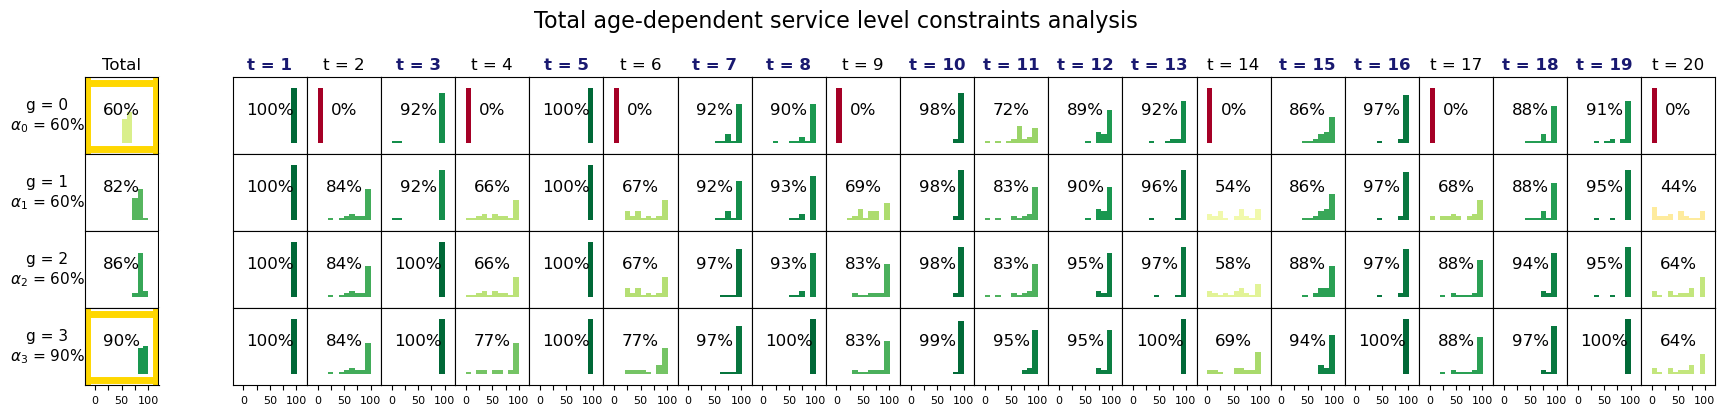

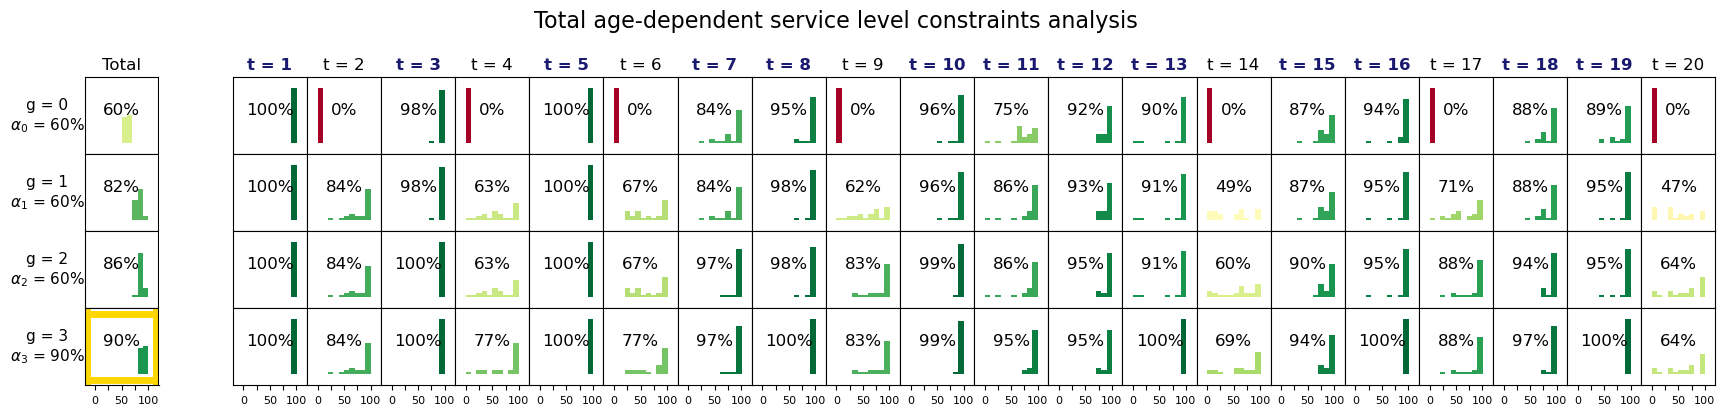

In [31]:
a = 0.6; b=0.9

_ = show_age_sl_results(T, G, S, alpha[a,b], d, y[a,b], z[a,b])
_ = show_age_sl_results(T, G, S, alpha[a,b], d, y2[a,b], z2[a,b])


# Formulations equivalence check

In [6]:
n = 4; G = list(range(n))
I0 = {g:0 for g in G[:-1]}; 

In [ ]:
verbose = False
a0 = [0.4, 0.5, 0.6]; an1 = [0.7, 0.8, 0.85, 0.9]

for s in [25, 50, 100, 150]:
    for tt in [10, 20, 30]:

        print(f" |S| = {s}, |T| = {tt}")

        T = 20; S = 25; n = 4
        T = list(range(1,T+1)); S = list(range(1,S+1))

        phi = {s:1/len(S) for s in S}
        d = {s:{t:5+20*np.random.random() for t in T} for s in S}

        C = np.max([np.floor(2*sum(list(d[s].values()))/len(T)) for s in S])

        for a in a0:
            for b in an1:
                
                alp = [b - (b - a)*(n-g-1)*(n-g)/(n*(n-1)) for  g in G]
                alpha = dict(zip(G,alp))

                t1, obj1 = stat_stat_standard_model(T, G, S, phi, n, h, f, C, I0, d, alpha, beta=0, epsilon=1, FIFO=False, verbose=verbose, time=True)
                t2, obj2 = stat_stat_transportation_model(T, G, S, phi, n, h, f, C, I0, d, alpha, beta=0, epsilon=1, verbose=verbose, time=True)

                print(f"\talpha_0 = {a:.0%}, alpha_n1 = {b:.0%}. {round(obj1,2)}-{round(obj2,2)}\tStandard = {round(t1,3)}, Transportation = {round(t2,3)}")

                